<a href="https://colab.research.google.com/github/jagvgithub/Aprendizaje_supervisado/blob/main/Actividad_C1_P1_Gomez_Vargas_Jose_Antonio_imagen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Internacional de Valencia
## Aprendizaje Supervizado
### Jose Antonio Gómez Vargas
### Actividad_C1_P1
#### Enlace directo GitHub:
###### https://colab.research.google.com/github/jagvgithub/Aprendizaje_supervisado/blob/main/Actividad_C1_P1_Gomez_Vargas_Jose_Antonio.ipynb#scrollTo=BESN9Pkf0ul-
##### Agosto - 2024

# 0) Cargar una de las imágenes histológicas

---
Librerías necesarias para el desarrollo de la actividad

---

In [58]:
import warnings
# Ignorar todos los warnings
warnings.filterwarnings('ignore')
import requests  # Librería para hacer solicitudes HTTP y descargar contenido de la web
from io import BytesIO  # Librería para manejar datos binarios en memoria como si fueran archivos
import matplotlib.pyplot as plt  # Librería de gráficos para crear visualizaciones y mostrar imágenes
from skimage import io  # Parte de `scikit-image`, proporciona funciones para leer y escribir imágenes
from PIL import Image  # Biblioteca para la manipulación de imágenes
import numpy as np  # Biblioteca para trabajar con arreglos y matrices
import cv2  # OpenCV para procesamiento de imágenes y visión por computadora
from skimage.morphology import remove_small_objects  # Función para eliminar objetos pequeños de una máscara binaria
from scipy.ndimage import binary_fill_holes  # Función para llenar huecos en objetos binarios
from skimage.measure import regionprops, label  # Funciones para medir propiedades de regiones etiquetadas
import math  # Biblioteca matemática para cálculos adicionales
import pandas as pd  # Biblioteca para el análisis y manipulación de datos tabulares

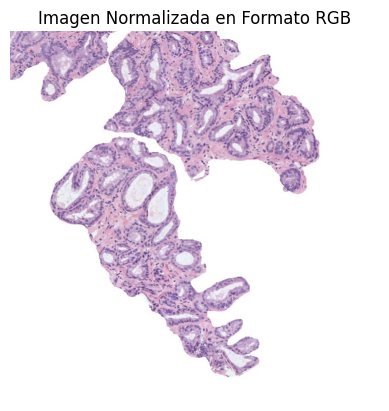

In [59]:
# URL de la imagen en GitHub
image_url = 'https://github.com/jagvgithub/Aprendizaje_supervisado/raw/main/histo_2.jpg'

# Descargar la imagen
response = requests.get(image_url)
image = io.imread(BytesIO(response.content))

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
image_normalized = image / 255.0

# Asegurarse de que la imagen esté en formato RGB
if len(image_normalized.shape) == 2:  # La imagen es en escala de grises
    image_normalized = io.gray2rgb(image_normalized)
elif image_normalized.shape[2] == 4:  # La imagen tiene un canal alfa (RGBA)
    image_normalized = image_normalized[:, :, :3]

# Visualizar la imagen
plt.imshow(image_normalized)
plt.axis('off')  # Ocultar los ejes
plt.title('Imagen Normalizada en Formato RGB')
plt.show()


# 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

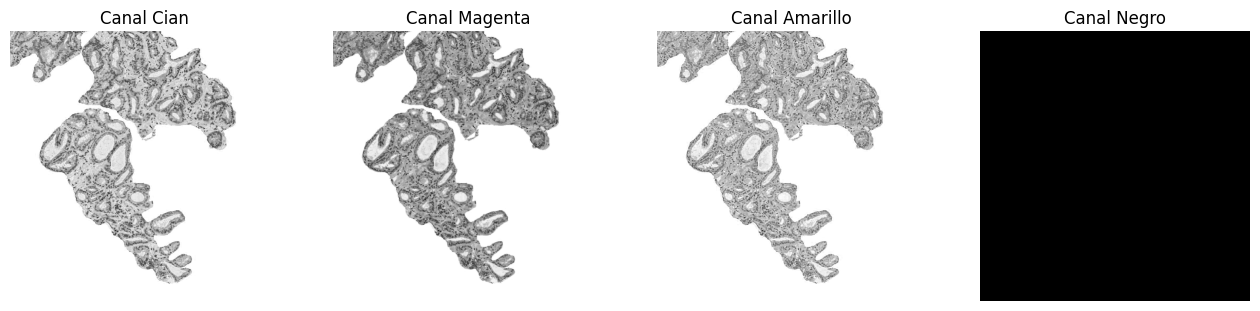

In [60]:
# Descargar la imagen
response = requests.get(image_url)
image_np = io.imread(BytesIO(response.content))

# Convertir la imagen numpy.ndarray a PIL.Image
image_pil = Image.fromarray((image_np * 255).astype('uint8'))

# Convertir la imagen al espacio de color CMYK
image_cmyk = image_pil.convert('CMYK')

# Obtener los canales CMYK
c, m, y, k = image_cmyk.split()

# Visualizar los canales CMYK
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(c, cmap='gray')
axes[0].set_title('Canal Cian')
axes[0].axis('off')

axes[1].imshow(m, cmap='gray')
axes[1].set_title('Canal Magenta')
axes[1].axis('off')

axes[2].imshow(y, cmap='gray')
axes[2].set_title('Canal Amarillo')
axes[2].axis('off')

axes[3].imshow(k, cmap='gray')
axes[3].set_title('Canal Negro')
axes[3].axis('off')

plt.show()


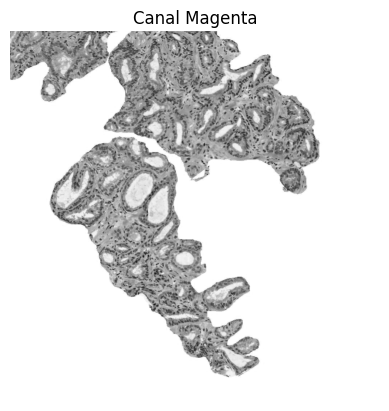

In [37]:
# Convertir la imagen numpy.ndarray a PIL.Image
image_pil = Image.fromarray((image_np * 255).astype('uint8'))

# Convertir la imagen al espacio de color CMYK
image_cmyk = image_pil.convert('CMYK')

# Obtener el canal magenta
_, magenta, _, _ = image_cmyk.split()

# Visualizar el canal magenta
plt.imshow(magenta, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Canal Magenta')
plt.show()

# 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

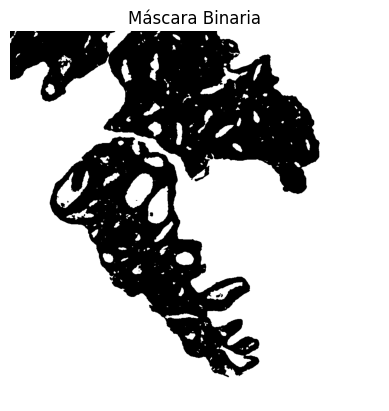

In [61]:
# Convertir la imagen al espacio de color CMYK
image_cmyk = image_pil.convert('CMYK')

# Obtener el canal magenta
_, magenta, _, _ = image_cmyk.split()

# Convertir la imagen de PIL a numpy array
magenta_np = np.array(magenta)

# Aplicar filtro gaussiano
magenta_blur = cv2.GaussianBlur(magenta_np, (5, 5), 0)

# Aplicar el método de Otsu
_, mask = cv2.threshold(magenta_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualizar la máscara binaria resultante
plt.imshow(mask, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Máscara Binaria')
plt.show()

# 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

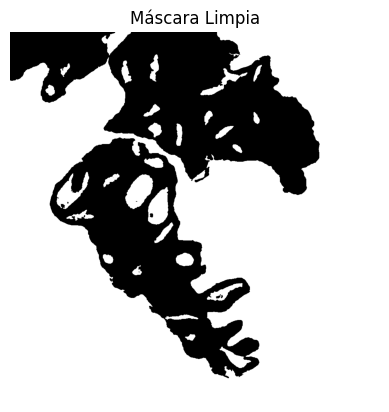

In [62]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
# Convertir la máscara a formato booleano

mask_bool = mask.astype(bool)

# Eliminar objetos pequeños
mask_cleaned = remove_small_objects(mask_bool, min_size=300)

# Convertir la máscara limpiada de nuevo a uint8 para visualizar
mask_cleaned_uint8 = (mask_cleaned * 255).astype('uint8')

# Visualizar la máscara limpia
plt.imshow(mask_cleaned_uint8, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Máscara Limpia')
plt.show()

# 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

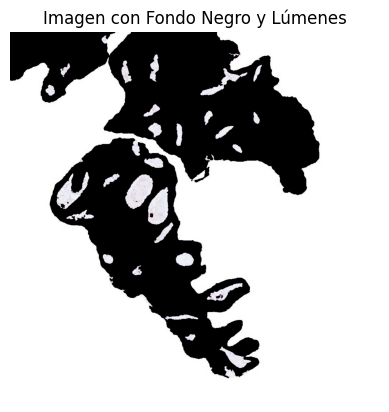

In [70]:
#Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

# Convertir la máscara limpia a formato booleano
mask_cleaned_bool = mask_cleaned.astype(bool)

# Crear una imagen en negro del mismo tamaño que la imagen original
image_lumen_only = np.zeros_like(image_np)

# Aplicar la máscara limpia a la imagen original para dejar solo los lúmenes
image_lumen_only[mask_cleaned_bool] = image_np[mask_cleaned_bool]

# Visualizar la imagen resultante con el fondo en negro
plt.imshow(image_lumen_only, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Imagen con Fondo Negro y Lúmenes')
plt.show()



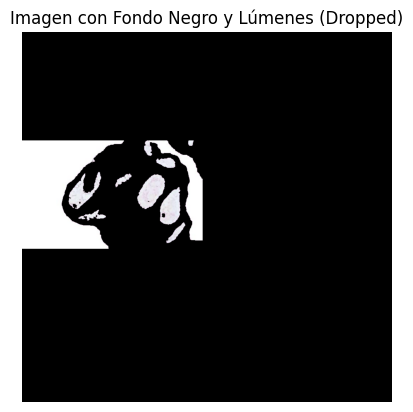

In [68]:
# Crear una nueva máscara para la región de interés (300:600 en y y 0:500 en x)
mask_region_of_interest = np.zeros_like(image_np, dtype=bool)
mask_region_of_interest[300:600, 0:500] = True

# Aplicar la máscara de la región de interés a la imagen de lúmenes
image_lumen_only[~mask_region_of_interest] = 0

# Visualizar la imagen resultante con el fondo en negro
plt.imshow(image_lumen_only, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Imagen con Fondo Negro y Lúmenes (Dropped)')
plt.show()

# 5) Rellenar los objetos de los lúmenes

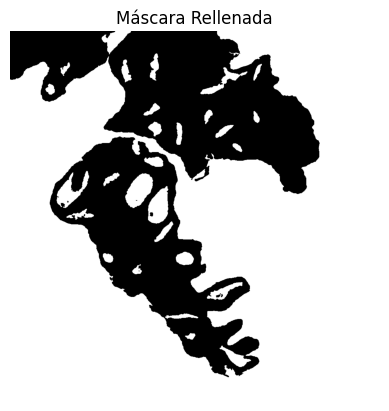

In [84]:
# Máscara binaria obtenida tras aplicar el método de Otsu y limpiar objetos pequeños
mask_cleaned_bool = image_lumen_only.astype(bool)

# Rellenar los lúmenes en la máscara limpia
mask_filled = binary_fill_holes(image_lumen_only)

# Convertir la máscara rellenada de nuevo a uint8 para visualizar
mask_filled_uint8 = (mask_filled * 255).astype('uint8')

# Visualizar la máscara rellenada
plt.imshow(mask_filled_uint8, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.title('Máscara Rellenada')
plt.show()


# 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Número de objetos:  2266
Posibles valores de intensidad:  [   0    1    2 ... 2264 2265 2266]


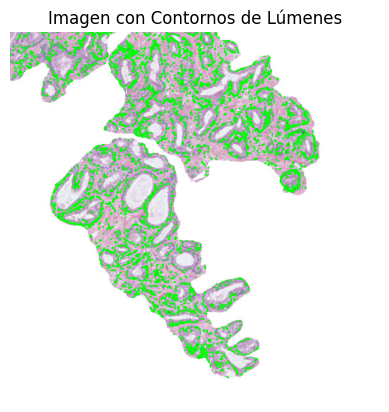

In [90]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.measure import label
from skimage.color import label2rgb

# URL de la imagen
image_url = 'https://github.com/jagvgithub/Aprendizaje_supervisado/raw/main/histo_2.jpg'

# Obtener la imagen de la URL
response = requests.get(image_url)
image_data = BytesIO(response.content)

# Leer la imagen en formato compatible con OpenCV
img = np.array(io.imread(image_data))

# Convertir la imagen de RGB a BGR (formato que usa OpenCV)
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral para segmentar los lúmenes
_, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
lab, num = label(mask, return_num=True)

# Imprimir el número de objetos y los posibles valores de intensidad
print('Número de objetos: ', num)
v, c = np.unique(lab, return_counts=True)
print('Posibles valores de intensidad: ', v)

# Encontrar contornos en la imagen etiquetada
contours = []
for i in range(1, num + 1):  # Saltamos el fondo que está etiquetado con 0
    mask = np.uint8(lab == i)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        contours.extend(cnts)

# Dibujar los contornos sobre la imagen original
img_contours = img_bgr.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

# Convertir la imagen de BGR a RGB para mostrarla con Matplotlib
img_contours_rgb = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con los contornos dibujados
plt.imshow(img_contours_rgb)
plt.axis('off')
plt.title('Imagen con Contornos de Lúmenes')
plt.show()

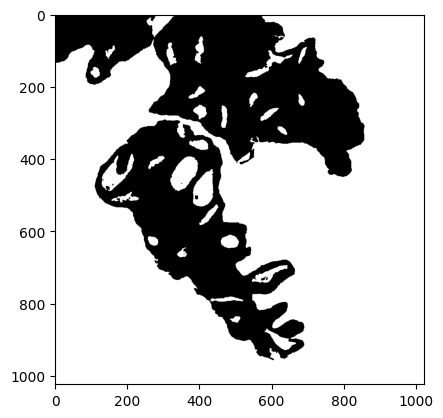

In [98]:
img_gray = cv2.cvtColor(mask_filled_uint8, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(img_gray,0,1,cv2.THRESH_OTSU)

plt.imshow(mask, cmap='gray')
plt.show()

número de objetos:  29
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


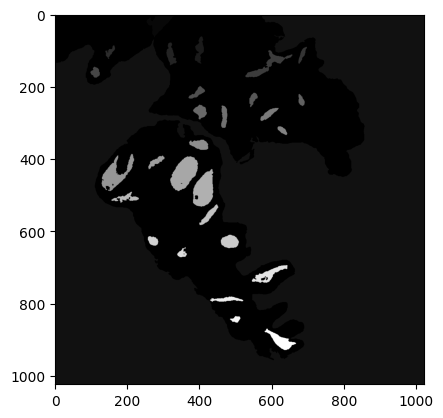

In [99]:
# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
from skimage.measure import label

lab, num = label(mask, return_num=True)

# Importante:
# En 'num' devuelve 6 valores correspondientes a los 6 objetos que hay en la imagen.
# Sin embargo, 'lab' contiene hasta 7 valores diferentes, ya que también tiene en cuenta el fondo de la imagen.
print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

plt.imshow(lab, cmap='gray')
plt.show()

In [107]:
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Suponiendo que 'lab' es la imagen etiquetada
# Identificar las regiones de los objetos
regions = regionprops(lab)

# Crear listas para las etiquetas y áreas
labels = []
areas = []

# Extraer etiqueta y área de cada región
for region in regions:
    labels.append(region.label)
    areas.append(region.area)

# Crear un DataFrame
df = pd.DataFrame({
    'Label': labels,
    'Area': areas
})

# Ordenar el DataFrame por área de mayor a menor
df_sorted = df.sort_values(by='Area', ascending=False).reset_index(drop=True)

# 7) Identificar y cropear el lumen más grande

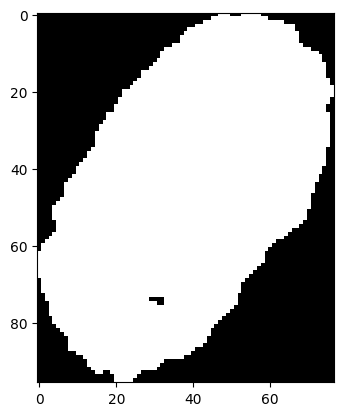

In [113]:
import numpy as np
from skimage.measure import regionprops
from skimage.draw import rectangle_perimeter
import matplotlib.pyplot as plt

# Suponiendo que 'lab' es la imagen etiquetada
# Obtener las propiedades de la región
regions = regionprops(lab)

# Encontrar la etiqueta del segundo objeto más grande
second_label = df_sorted.iloc[1]['Label']

# Encontrar la región correspondiente a la etiqueta
second_region = next(region for region in regions if region.label == second_label)

# Obtener las coordenadas del rectángulo que encierra el objeto
minr, minc, maxr, maxc = second_region.bbox

# Recortar la imagen binaria 'objeto'
cropped_objeto = objeto[minr:maxr, minc:maxc]

# Crear una imagen en blanco del mismo tamaño que el recorte
contour_image = np.zeros_like(cropped_objeto)

# Dibujar el contorno alrededor del objeto
rr, cc = rectangle_perimeter(start=(0, 0), end=cropped_objeto.shape, shape=cropped_objeto.shape)
contour_image[rr, cc] = 1

# Superponer el contorno en la imagen recortada
cropped_with_contour = np.maximum(cropped_objeto, contour_image)

# Mostrar la imagen recortada con contorno
plt.imshow(cropped_with_contour, cmap='gray')
plt.show()


# Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [115]:
import numpy as np
import cv2
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import pandas as pd
import math

# Suponiendo que 'cropped_lumen' es la imagen del lumen recortada y 'mask_filled_uint8' es la imagen binaria llena
# Aquí están las dimensiones del lumen recortado
height, width, _ = cropped_lumen.shape
print(f"Dimensiones del lumen cropeado: Altura = {height} píxeles, Ancho = {width} píxeles")

# Obtener las propiedades de la región usando regionprops
labeled_crop = label(cropped_lumen[:, :, 0])  # Asumiendo que la imagen binaria está en el canal rojo
props = regionprops(labeled_crop)[0]

# Área
area = props.area

# Área de la bounding box
bounding_box_area = (props.bbox[2] - props.bbox[0]) * (props.bbox[3] - props.bbox[1])

# Área convexa
convex_area = props.convex_area

# Excentricidad
eccentricity = props.eccentricity

# Diámetro equivalente
equivalent_diameter = props.equivalent_diameter

# Extensión
extent = props.extent

# Perímetro
perimeter = props.perimeter

# Longitud del eje mayor
major_axis_length = props.major_axis_length

# Longitud del eje menor
minor_axis_length = props.minor_axis_length

# Orientación
orientation = props.orientation

# Solidez
solidity = props.solidity

# Compacidad
compactness = perimeter**2 / (4 * math.pi * area)

# Contorno del objeto
contours, _ = cv2.findContours(cropped_lumen[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]  # Usar el contorno del objeto de interés

# Diámetro de Feret
diameter_feret = max([cv2.norm(contour[i] - contour[j]) for i in range(len(contour)) for j in range(i+1, len(contour))])



# Redondear los valores hasta el cuarto decimal
features = {
    'Área': round(area, 4),
    'Área de la bounding box': round(bounding_box_area, 4),
    'Área convexa': round(convex_area, 4),
    'Excentricidad': round(eccentricity, 4),
    'Diámetro equivalente': round(equivalent_diameter, 4),
    'Extensión': round(extent, 4),
    'Diámetro Feret': round(diameter_feret, 4),
    'Longitud del eje mayor': round(major_axis_length, 4),
    'Longitud del eje menor': round(minor_axis_length, 4),
    'Orientación': round(orientation, 4),
    'Perímetro': round(perimeter, 4),
    'Solidez': round(solidity, 4),
    'Compacidad': round(compactness, 4)
}

features_df = pd.DataFrame(features.items(), columns=['Característica', 'Valor'])
# Mostrar las características
print(features_df)


Dimensiones del lumen cropeado: Altura = 27 píxeles, Ancho = 61 píxeles
             Característica     Valor
0                      Área   76.0000
1   Área de la bounding box  196.0000
2              Área convexa  113.0000
3             Excentricidad    0.7918
4      Diámetro equivalente    9.8370
5                 Extensión    0.3878
6            Diámetro Feret   65.3911
7    Longitud del eje mayor   16.8541
8    Longitud del eje menor   10.2948
9               Orientación   -0.8490
10                Perímetro   48.8995
11                  Solidez    0.6726
12               Compacidad    2.5037


---
Cierre del ejercicio

---
